In [3]:
import numpy as np

import plotly
import plotly.graph_objs as go

import matplotlib.pyplot as plt
from surface_curvature import surface_curvature

102
180
(18360,)


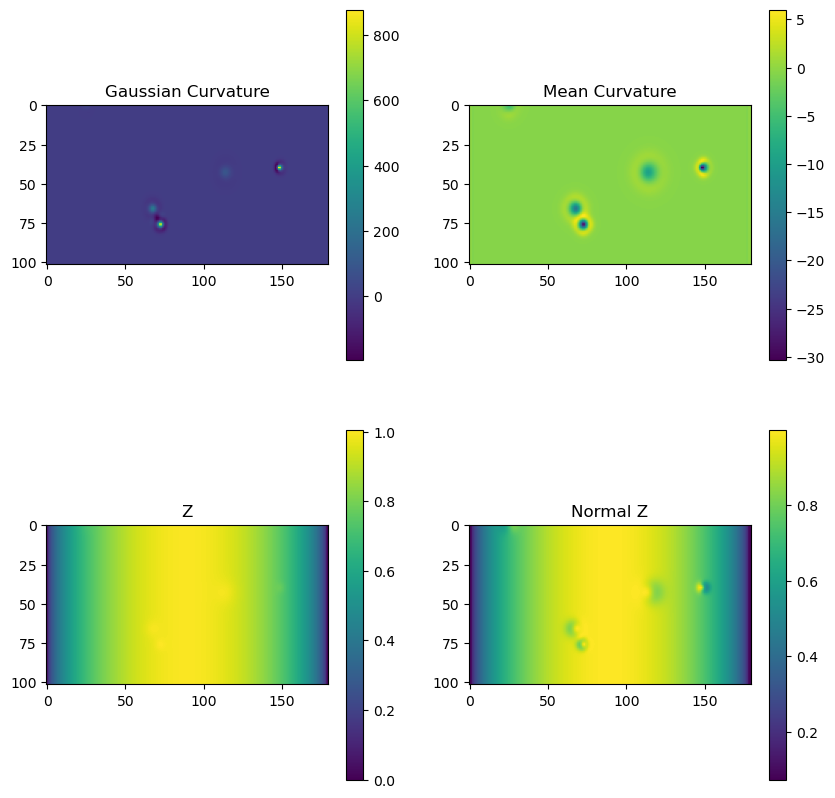

In [14]:
def create_half_cylinder_with_multiple_pits(radius, height, density_x, density_y, pits):
    """
    Create a half cylinder with multiple pitting defects.

    Parameters:
    radius (float): Radius of the cylinder.
    height (float): Height of the cylinder.
    density_x (int): Density of the meshgrid in the x direction.
    density_y (int): Density of the meshgrid in the y direction.
    
    pits (list of tuples): A list where each tuple represents a pit.
                           Each tuple is (pit_depth, pit_width, pit_center).
                           pit_center is a tuple (x, y).
    """
    # Create the meshgrid
    x = np.linspace(-radius, radius, density_x)
    y = np.linspace(0, height, density_y)
    X, Y = np.meshgrid(x, y)

    # Calculate Z for the upper half of the cylinder
    Z_square = radius**2 - X**2
    Z_square[Z_square < 0] = 0
    Z = np.sqrt(Z_square)

    # Initialize the half-cylinder structure
    half_cylinder = np.zeros((density_y, density_x, 3))
    half_cylinder[:, :, 0] = X
    half_cylinder[:, :, 1] = Y
    half_cylinder[:, :, 2] = Z

    # Add each corrosion pit
    for pit_depth, pit_width, pit_center in pits:
        x0, y0 = pit_center
        sigma_x, sigma_y = pit_width, pit_width

        # Apply Gaussian function for each pit
        for i in range(half_cylinder.shape[0]):
            for j in range(half_cylinder.shape[1]):
                x_val = half_cylinder[i, j, 0]
                y_val = half_cylinder[i, j, 1]
                pit = pit_depth * np.exp(-((x_val - x0)**2 / (2 * sigma_x**2) + (y_val - y0)**2 / (2 * sigma_y**2)))
                half_cylinder[i, j, 2] += pit  # adds the pit depth to Z

    return half_cylinder

def pit_generator(max_pits, cyl_radius, cyl_height):
    '''
    Genreate random pits on the half cylinder based on the maximum number of pits.
    Size the pits based on the radius and height of the cylinder.
    '''
    pits = []
    num_pits = np.random.randint(1, max_pits)
    for _ in range(num_pits):
        pit_depth = np.random.uniform(0.01, 0.03)
        pit_width = np.random.uniform(0.02, 0.06)
        pit_center = (np.random.uniform(-cyl_radius*0.8, cyl_radius*0.8), np.random.uniform(0, cyl_height))
        pits.append((pit_depth, pit_width, pit_center))
    
    return pits

pits = pit_generator(max_pits=10, cyl_radius=1, cyl_height=1)


half_cylinder_with_pits = create_half_cylinder_with_multiple_pits(radius=1, height=1, density_x = 180, density_y = 102, pits=pits)

X = half_cylinder_with_pits[:, :, 0]
Y = half_cylinder_with_pits[:, :, 1]
Z = half_cylinder_with_pits[:, :, 2]

# plot the half cylinder with plotly as an interactive 3D plot
fig = go.Figure(data=[go.Surface(x=X, y=Y, z=Z)])
fig.update_layout(title='Half Cylinder with Multiple Corrosion Pits', autosize=False,
                    width=500, height=500,
                    margin=dict(l=65, r=50, b=65, t=90))
fig.show()

# compute the surface curvature
K, H, n, Principal = surface_curvature(X.astype(np.float64), Y.astype(np.float64), Z.astype(np.float64))

# transpose all the arrays to make them compatible with the meshgrid

# plot K, H, n
fig = plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.imshow((K).reshape(X.shape), cmap='viridis')
plt.colorbar()
plt.title('Gaussian Curvature')
plt.subplot(2, 2, 2)
plt.imshow((H).reshape(X.shape), cmap='viridis')
plt.colorbar()
plt.title('Mean Curvature')
plt.subplot(2, 2, 3)
plt.imshow((Z).reshape(X.shape), cmap='viridis')
plt.colorbar()
plt.title('Z')
plt.subplot(2, 2, 4)
plt.imshow((n[:, 2]).reshape(X.shape), cmap='viridis')
plt.title('Normal Z')
plt.colorbar()
plt.show()



In [22]:
# now create a dataset of depth, K, H, n images for training a neural network
# we will use the half cylinder with pits as the input and the K, H, n images as the output

# n_train 
n_train = 200

# create 1000 half cylinders with pits - the image dimension is 102x180

def pit_generator(max_pits, cyl_radius, cyl_height):
    '''
    Genreate random pits on the half cylinder based on the maximum number of pits.
    Size the pits based on the radius and height of the cylinder.
    '''
    pits = []
    num_pits = np.random.randint(1, max_pits)
    for _ in range(num_pits):
        pit_depth = np.random.uniform(0.01, 0.03)
        pit_width = np.random.uniform(0.02, 0.06)
        pit_center = (np.random.uniform(-cyl_radius*0.8, cyl_radius*0.8), np.random.uniform(0, cyl_height))
        pits.append((pit_depth, pit_width, pit_center))
    
    return pits

pits = pit_generator(max_pits=10, cyl_radius=1, cyl_height=1)

half_cylinders = []
for i in range(n_train):
    pits = pit_generator(max_pits=10, cyl_radius=1, cyl_height=1)
    half_cylinder_with_pits = create_half_cylinder_with_multiple_pits(radius=1, height=1, density_x = 180, density_y = 102, pits=pits)
    half_cylinders.append(half_cylinder_with_pits)


# create the K, H, n, Z images
K_images = []
H_images = []
n_images = []
Z_images = []

for i in range(n_train):    
    X = half_cylinders[i][:, :, 0]
    Y = half_cylinders[i][:, :, 1]
    Z = half_cylinders[i][:, :, 2]
    K, H, n, Principal = surface_curvature(X.astype(np.float64), Y.astype(np.float64), Z.astype(np.float64))
    K_images.append(K)
    H_images.append(H)
    n_images.append(n)
    Z_images.append(Z)

K_images = np.array(K_images)
H_images = np.array(H_images)
n_images = np.array(n_images)
Z_images = np.array(Z_images)

# save the images as png files
import cv2
import os

root_dir = 'data'
simulatedMeanCurvature = os.path.join(root_dir, 'simulatedMeanCurvature')
simulatedGaussianCurvature = os.path.join(root_dir, 'simulatedGaussianCurvature')
simulatedNormal = os.path.join(root_dir, 'simulatedNormal')
simulatedZ = os.path.join(root_dir, 'simulatedZ')
if not os.path.exists(simulatedMeanCurvature):
    os.mkdir(simulatedMeanCurvature)
if not os.path.exists(simulatedGaussianCurvature):
    os.mkdir(simulatedGaussianCurvature)
if not os.path.exists(simulatedNormal):
    os.mkdir(simulatedNormal)
if not os.path.exists(simulatedZ):
    os.mkdir(simulatedZ)

for i in range(n_train):
    cv2.imwrite(os.path.join(simulatedMeanCurvature, f'{i}.png'), K_images[i])
    cv2.imwrite(os.path.join(simulatedGaussianCurvature, f'{i}.png'), H_images[i])
    cv2.imwrite(os.path.join(simulatedNormal, f'{i}.png'), n_images[i])
    cv2.imwrite(os.path.join(simulatedZ, f'{i}.png'), Z_images[i])
    


102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360,)
102
180
(18360